In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import mne
import re
import time
import shutil
from operator import itemgetter
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

### Obtención de gráfica para un individuo y consenso de anotaciones

In [22]:
class EegDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.transform = transform
        self.labels = pd.read_csv('../data/labels.csv')
        
    def __len__(self):
        return len(self.labels.columns)
    
    def item(self,idx):
        raw_file = f'../data/eeg{idx+1}.edf'
        raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
        data = raw.get_data()
        names = map(str.upper, raw.ch_names)
        names = [n + "-REF" if not re.search("-REF", n) else n for n in names]
        sample = data[np.argsort(names), :]
        names = np.sort(names)
        # Labels son la columna idx+1 del csv, un vector de 0s y 1s
        label = self.labels.iloc[:, idx].values.astype('float')
        return sample, label, names
    
    # Los individuos van de 0 a 78, pero los archivos de 1 a 79, y las labels de 0 a 78
    def __getitem__(self, idx):
        sample, label, _ = self.item(idx)
        if self.transform:
            sample = self.transform(sample)
        return sample, label
    
    

In [23]:
# Test dataset
eeg_dataset = EegDataset()

0


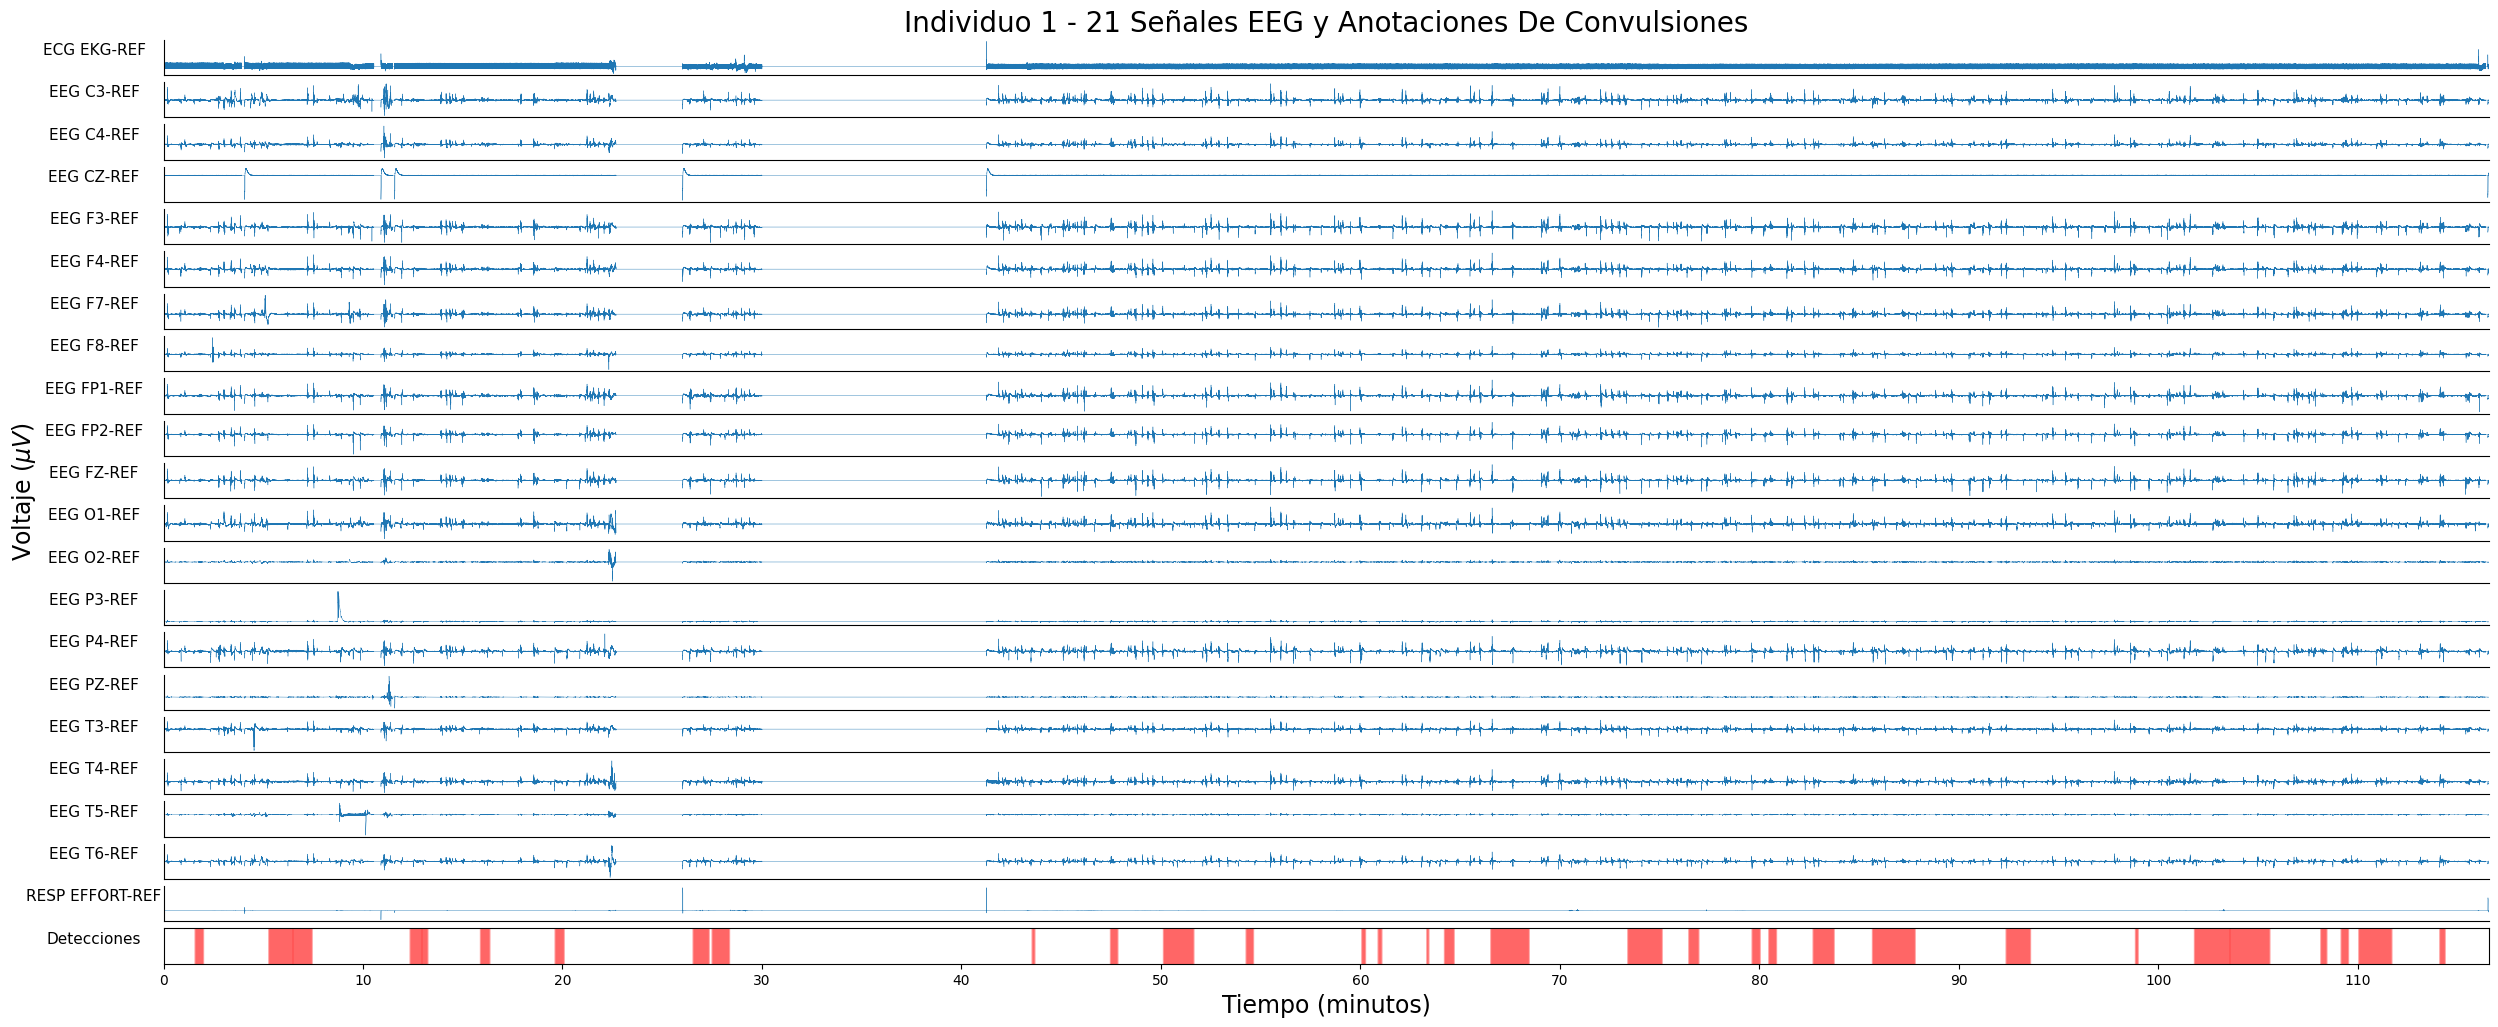

In [88]:
# Graficar un individuo para las 21 señales
sample, detections, names = eeg_dataset.item(0)

fig, axs = plt.subplots(len(names)+1, 1, figsize=(30, 12))
for ax, name, signal in zip(axs[:-1], names, sample):
    ax.plot(signal, linewidth=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0, len(sample[0])])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(name, rotation=0, labelpad=50, fontsize=11)
    
for i, detection in enumerate(detections):
    if detection == 1:
        axs[-1].axvline(x=256*i, color='red', linewidth=0.1)
        axs[-1].axvline(x=256*(i+1), color='red', linewidth=0.1)

# X ticks cada 30min, es decir, /256*60*30
axs[-1].set_xticks(np.arange(0, len(sample[0]), 256*60*10))
axs[-1].set_xticklabels(np.arange(0, len(sample[0])//(256*60)+1, 10))

# Agregar caja de texto simulando un eje y en el ax[10]
axs[10].text(-0.06, 0.2, 'Voltaje ($\mu V$)', horizontalalignment='center', verticalalignment='center', transform=axs[10].transAxes, rotation=90, fontsize=17) 
  
axs[-1].set_xlabel('Tiempo (minutos)', fontsize=17)
axs[-1].set_ylabel('Detecciones', rotation=0, labelpad=50, fontsize=11)
axs[-1].set_xlim([0, len(sample[0])])
axs[-1].set_yticks([])
# Guardar la figura en svg
axs[0].set_title('Individuo 1 - 21 Señales EEG y Anotaciones De Convulsiones', fontsize=20)
# Guardar sin bordes
plt.savefig('eeg.svg', format='svg', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()
    

In [ ]:
# # Crear modelo autoregresivo para predecir la siguiente muestra (por ahora no se usa)

# class Autoregressive(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.linear = nn.Linear(hidden_size, output_size)
        
#     def forward(self, x):
#         # x: (batch_size, seq_len, input_size)
#         batch_size, seq_len, input_size = x.shape
#         # hidden: (num_layers, batch_size, hidden_size)
#         hidden = self.init_hidden(batch_size)
#         # output: (batch_size, seq_len, hidden_size)
#         output, _ = self.lstm(x, hidden)
#         # output: (batch_size, seq_len, output_size)
#         output = self.linear(output)
#         return output
    
#     def init_hidden(self, batch_size):
#         return (torch.zeros(1, batch_size, self.hidden_size),
#                 torch.zeros(1, batch_size, self.hidden_size))